In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# read in dataset
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t')
print(dataset.shape)

# replace liked vales
dataset['Liked'] = np.where(dataset["Liked"]==1, 0, 1)

(1000, 2)


In [4]:
# libraries to clean data
import re
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# data preprocessing
corpus = []
for i in range(0, 1000):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'].iloc[i])
    review = review.lower()
    review = review.split()
    
    ps = PorterStemmer()
    lemm = WordNetLemmatizer()
    #review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review = [lemm.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    
    # convert back to string
    review = " ".join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jfeng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# NLP CountVecotrizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 1].values

In [6]:
# identify which occured more than twice
index = np.where(X>2)

# convert zip to dict for print/view
d = dict(zip([cv.get_feature_names()[i] for i in index[1]], X[index]))

# sorted by dict value
sorted( ((v,k) for k,v in d.items()), reverse=True)

[(4, 'steak'),
 (3, 'waited'),
 (3, 'wait'),
 (3, 'sauce'),
 (3, 'said'),
 (3, 'great'),
 (3, 'good'),
 (3, 'food')]

In [7]:
# RF training model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = RandomForestClassifier(n_estimators = 200, random_state=137, 
                                n_jobs=-1, max_depth=5, criterion = 'entropy')

# base model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
probs_base = model.predict_proba(X_test)
acc_base = roc_auc_score(y_test, probs_base[:, 1])
fpr_base, tpr_base, thresholds = roc_curve(y_test,probs_base[:, 1])
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(f'base model:\n {cm}')
print(f"auc score: {acc_base:.4f}")
print(f"ks score: {max(tpr_base - fpr_base):.4f}")

+++++++++++++++++++++++++++++++++++++++++++++++++++++
base model:
 [[ 72  50]
 [ 17 111]]
auc score: 0.8283
ks score: 0.5087


In [8]:
dataset["word count"] = dataset["Review"].str.count(" ") + 1
dataset.groupby(["Liked"])["word count"].mean()

Liked
0    10.290
1    11.498
Name: word count, dtype: float64

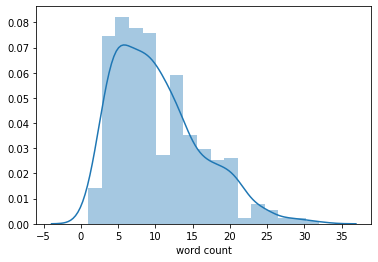

In [9]:
import seaborn as sns
%matplotlib inline

data = dataset[dataset["Liked"]==0]
sns.distplot(data["word count"])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
print(sorted(zip(map(lambda x: round(x, 3), 
                     model.feature_importances_),
                     cv.get_feature_names()), reverse=True)[:15])

[(0.105, 'great'), (0.04, 'delicious'), (0.039, 'good'), (0.025, 'minute'), (0.023, 'nice'), (0.022, 'bad'), (0.021, 'friendly'), (0.02, 'took'), (0.018, 'perfect'), (0.017, 'amazing'), (0.016, 'bland'), (0.015, 'loved'), (0.015, 'excellent'), (0.014, 'coming'), (0.011, 'awesome')]


In [12]:
# Create the random grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [False, True]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# random search training
rf = RandomForestClassifier(random_state=137)
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, error_score=np.nan, iid=False,
                               random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('grid searched best parmeters:\n')
best_random = rf_random.best_estimator_
print(best_random)

# use best estimater to estimate performance
random_accuracy = best_random.predict(X_test)
cm = confusion_matrix(y_test, random_accuracy)

probs_random = best_random.predict_proba(X_test)
acc_random = roc_auc_score(y_test, probs_random[:, 1])
fpr_random, tpr_random, thresholds = roc_curve(y_test,probs_random[:, 1])
print('results from best parameters:\n')
print(f'base model:\n {cm}')
print(f"auc score: {acc_random:.4f}")
print(f"ks score: {max(tpr_random - fpr_random):.4f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


+++++++++++++++++++++++++++++++++++++++++++++++++++++
grid searched best parmeters:

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=77, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=None, oob_score=False, random_state=137,
                       verbose=0, warm_start=False)
results from best parameters:

base model:
 [[ 87  35]
 [ 28 100]]
auc score: 0.8552
ks score: 0.5415


In [15]:
print(sorted(zip(map(lambda x: round(x, 4), best_random.feature_importances_), 
                 cv.get_feature_names()), reverse=True)[:10])

[(0.0568, 'great'), (0.0252, 'good'), (0.0214, 'delicious'), (0.0136, 'bad'), (0.0132, 'amazing'), (0.0124, 'nice'), (0.0119, 'friendly'), (0.0114, 'love'), (0.0111, 'minute'), (0.011, 'awesome')]


In [16]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15, 25],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [3, 5,10,25],
    'min_samples_split': [3, 5, 8],
    'n_estimators': [100, 200, 600,1000]
}
# Create a based model
rf = RandomForestClassifier(random_state=137, oob_score=True)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                     cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_test, y_test)
print('best grid parameter with CV: \n')
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = best_grid.predict(X_test)
cm = confusion_matrix(y_test, grid_accuracy)

probs_grid = best_grid.predict_proba(X_test)
acc_grid = roc_auc_score(y_test, probs_grid[:, 1])
fpr_grid, tpr_grid, thresholds = roc_curve(y_test,probs_grid[:, 1])
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(f'base model:\n {cm}')
print(f"auc score: {acc_grid:.4f}")
print(f"ks score: {max(tpr_grid - fpr_grid):.4f}")   

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  3.4min finished


best grid parameter with CV: 

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 600}
+++++++++++++++++++++++++++++++++++++++++++++++++++++
base model:
 [[ 71  51]
 [  7 121]]
auc score: 0.9122
ks score: 0.6848


In [17]:
# save trained model
filename = 'restaurant_best_grid.pkl'
#pickle.dump(best_grid, open(filename, 'wb'))

In [26]:
# load saved model
filename = 'restaurant_best_grid.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.48


C:\Users\jfeng\AppData\Local\Continuum\miniconda3\envs\datascience\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\jfeng\AppData\Local\Continuum\miniconda3\envs\datascience\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.20.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


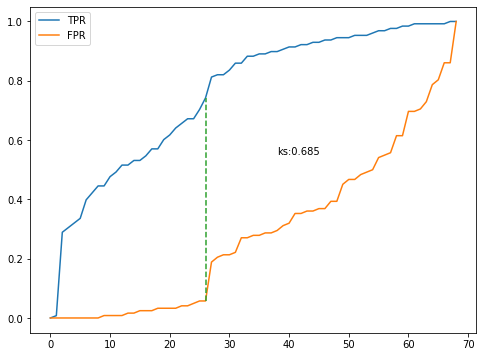

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

# location of max ks
ks1 = tpr_grid - fpr_grid
index = np.argmax(ks1)

serial = range(len(tpr_grid))
ax.plot(serial, tpr_grid, label='TPR')
ax.plot(serial, fpr_grid, label='FPR')
ax.plot([serial[index], serial[index]], [fpr_grid[index], tpr_grid[index]], '--')
ax.text(38, 0.55, f"ks:{max(ks1):.3f}")
plt.legend()

In [28]:
print(sorted(zip(map(lambda x: round(x, 4), best_grid.feature_importances_), 
                 cv.get_feature_names()), reverse=True)[:25])

[(0.0611, 'great'), (0.0379, 'worst'), (0.0376, 'never'), (0.0359, 'would'), (0.0359, 'think'), (0.0336, 'amazing'), (0.0302, 'also'), (0.0264, 'staff'), (0.0254, 'good'), (0.0242, 'eat'), (0.0229, 'friendly'), (0.022, 'fantastic'), (0.0202, 'way'), (0.0194, 'got'), (0.0175, 'ever'), (0.0174, 'minute'), (0.0174, 'disappointed'), (0.0165, 'star'), (0.0163, 'another'), (0.0162, 'get'), (0.0155, 'place'), (0.0147, 'could'), (0.0146, 'nice'), (0.0139, 'terrible'), (0.0132, 'time')]


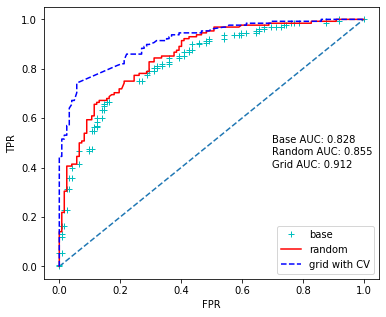

In [29]:
#AOC curve display
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot([0, 1], [0, 1], '--')
ax.plot(fpr_base, tpr_base, 'c+', label='base')
ax.plot(fpr_random, tpr_random, 'r-', label='random')
ax.plot(fpr_grid, tpr_grid, 'b--', label='grid with CV')
ax.text(0.7, 0.5, "Base AUC: " + str(round(acc_base,3)))
ax.text(0.7, 0.45, "Random AUC: " + str(round(acc_random,3)))
ax.text(0.7, 0.4, "Grid AUC: " + str(round(acc_grid,3)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

### There are primarily 3 features which can be tuned to improve the predictive power of the model :

<div class="alert alert-block alert-info">
<b>Main parameters to adjust:</b><span style="color:red"> *n_estimators* and *max_features*</span>. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. 
</div>

The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=n_features for regression problems, and max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in the data). 

Good results are often achieved when setting <span style="color:blue"> max_depth=None </span> in combination with <span style="color:blue">min_samples_split=2 </span>(i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.

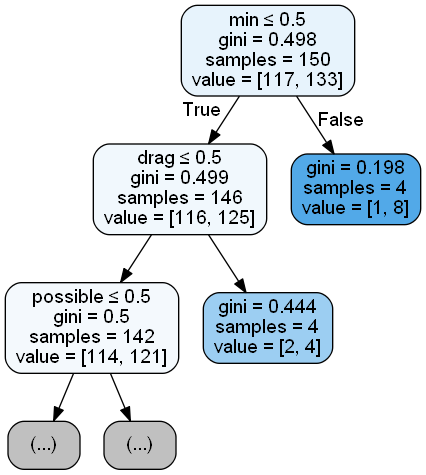

In [46]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

N_tree = np.random.randint(1,len(loaded_model.estimators_))
dtree = loaded_model.estimators_[N_tree]
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names=cv.get_feature_names(),
                special_characters=True,
                max_depth=2,
                proportion=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 0 - BAD Review; 1 - GOOD Review.

In [47]:
from sklearn.tree.export import export_text
r = export_text(dtree, 
                feature_names=cv.get_feature_names(), 
                show_weights=True)
print(r)

|--- min <= 0.50
|   |--- drag <= 0.50
|   |   |--- possible <= 0.50
|   |   |   |--- worth <= 0.50
|   |   |   |   |--- weights: [106.00, 121.00] class: 1.0
|   |   |   |--- worth >  0.50
|   |   |   |   |--- weights: [4.00, 0.00] class: 0.0
|   |   |--- possible >  0.50
|   |   |   |--- weights: [4.00, 0.00] class: 0.0
|   |--- drag >  0.50
|   |   |--- weights: [2.00, 4.00] class: 1.0
|--- min >  0.50
|   |--- weights: [1.00, 8.00] class: 1.0



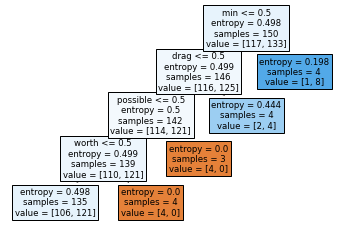

In [48]:
from sklearn import tree
tree.plot_tree(dtree, feature_names=cv.get_feature_names(), filled=True);

### study the validation dataset construction

In [49]:
import string
vals = pd.read_csv("Restaurant_Reviews -validation.tsv", delimiter='\t')
vals["Liked"] = np.where(vals["Liked"]==1, 0, 1)

vals["Review"] = vals["Review"].apply(lambda x: x.lower())
vals["Review"] = vals["Review"].replace('\d+', "", regex=True)
vals["Review"] = vals["Review"].str.replace('[{}]'.format(string.punctuation), '')
vals

,Review,Liked
0,it is not too bad at all,0
1,crust is not good,1
2,i am not very satisfied with the quality,1
3,i am satisfied with the quality,0
4,the selection on the menu was great and so wer...,0
5,now i am getting angry and i want my damn pho,1
6,honeslty it taste stale,1


In [50]:
# count words per each comment and list shorted comments
dataset["word_count"] = dataset["Review"].str.count(' ') + 1
print(dataset[["word_count"]].describe())
print(dataset[dataset["word_count"]==1])

# check if validate words in training set
word_list = []
for comment in corpus:
    word_list.extend([x for x in  comment.split(" ")])
print(len(word_list))

# convert dataset reviews to a word list
word_list =  dataset['Review'].str.split(" ").sum()

# count most common words
from collections import Counter
print(Counter(word_list).most_common(3))
d = dict(Counter(word_list))

# check how many words from validation set in training set
vals["words_occured"] = vals["Review"].apply(lambda x: ' '.join([word for word in x.split() if word in set(word_list)]))
vals["words count"] = vals["words_occured"].str.count(' ') + 1
print(vals)

        word_count
count  1000.000000
mean     10.894000
std       6.257469
min       1.000000
25%       6.000000
50%      10.000000
75%      15.000000
max      32.000000
          Review  Liked  word count  word_count
165  DELICIOUS!!      0           1           1
5486
[('the', 405), ('and', 378), ('I', 294)]
                                              Review  Liked  \
0                           it is not too bad at all      0   
1                                  crust is not good      1   
2           i am not very satisfied with the quality      1   
3                    i am satisfied with the quality      0   
4  the selection on the menu was great and so wer...      0   
5      now i am getting angry and i want my damn pho      1   
6                            honeslty it taste stale      1   

                                       words_occured  words count  
0                           it is not too bad at all            7  
1                                  crust is no

In [51]:
# predict on validation dataset
vals_x = cv.transform(vals["Review"]).toarray()
vals_y = vals.iloc[:, 1].values

# results
grid_accuracy = best_grid.predict(vals_x)
cm = confusion_matrix(vals_y, grid_accuracy)

probs_grid = best_grid.predict_proba(vals_x)
acc_grid = roc_auc_score(vals_y, probs_grid[:, 1])
fpr_grid, tpr_grid, thresholds = roc_curve(vals_y,probs_grid[:, 1])
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(f'base model:\n {cm}')
print(f"auc score: {acc_grid:.4f}")
print(f"ks score: {max(tpr_grid - fpr_grid):.4f}") 

vals["Predict"] = best_grid.predict(vals_x)
vals["Flag"] = np.where(vals["Liked"]==vals["Predict"], "Right", "Wrong")

vals

+++++++++++++++++++++++++++++++++++++++++++++++++++++
base model:
 [[1 2]
 [1 3]]
auc score: 0.5417
ks score: 0.3333


,Review,Liked,words_occured,words count,Predict,Flag
0,it is not too bad at all,0,it is not too bad at all,7,1,Wrong
1,crust is not good,1,crust is not good,4,0,Wrong
2,i am not very satisfied with the quality,1,i am not very with the quality,7,1,Right
3,i am satisfied with the quality,0,i am with the quality,5,1,Wrong
4,the selection on the menu was great and so wer...,0,the selection on the menu was great and so wer...,12,0,Right
5,now i am getting angry and i want my damn pho,1,now i am getting angry and i want my damn pho,11,1,Right
6,honeslty it taste stale,1,it taste,2,1,Right


### training and test predict probability range

[Text(0, 0.5, ''), Text(0.5, 0, 'probability')]

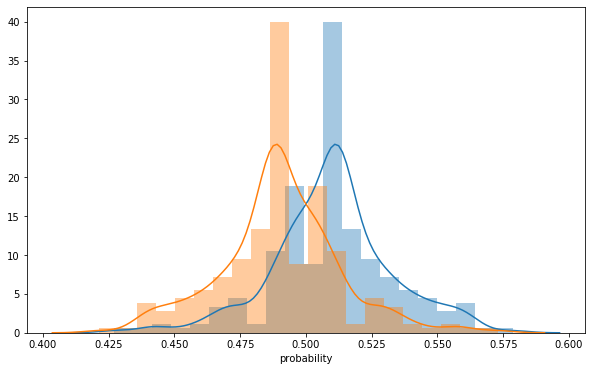

In [64]:
probs_grid = best_grid.predict_proba(X_test)
good, bad = zip(*probs_grid)

data = pd.DataFrame({'bad':bad, 'good':good})

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
for col in data.columns:
    ax = sns.distplot(data[col], kde=True)
    
ax.set(xlabel='probability', ylabel='')

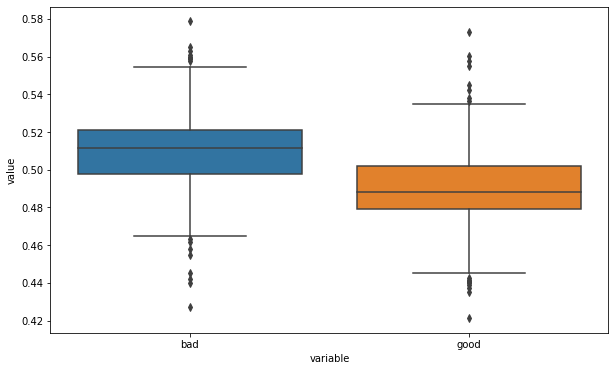

In [65]:
df_all = pd.melt(data, value_vars=['bad', 'good'])
fig = plt.figure(figsize=(10, 6))
sns.boxplot(x = "variable", y="value", data=df_all)

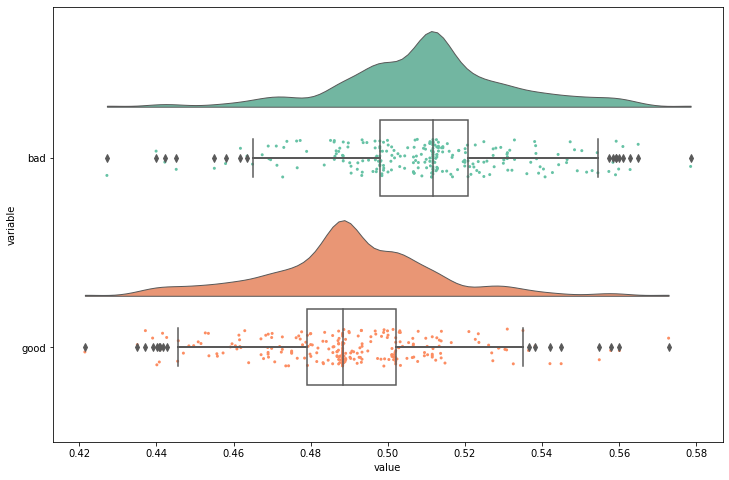

In [66]:
import ptitprince as pt
ax = pt.RainCloud(x = 'variable', y = 'value', 
                  data = df_all, 
                  width_viol = .8,
                  width_box = .4,
                  figsize = (12, 8), orient = 'h',
                  move = .0)

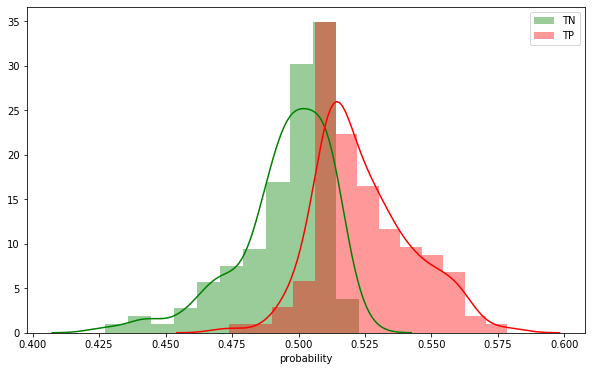

In [67]:
df = pd.DataFrame({'y_test':y_test, 'good':good, 'bad':bad})

good_review = df.loc[df["y_test"]==0, "bad"]
bad_review = df.loc[df["y_test"]==1, "bad"]

color = ['g', 'r']
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.distplot(good_review, kde=True, color=color[0], label="TN")
ax = sns.distplot(bad_review, kde=True, color=color[1], label='TP')
    
ax.set(xlabel='probability', ylabel='')
plt.legend()